# CCN Assignment 5: Reinforcement Learning
By: Luca Parolo & Emiel Stoelinga

In the current assignment, several reinforcement learning algorithms will be examined and implemented in a simple environment.

First basic libraries are imported.

In [52]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from my_env import EvidenceEnv

### Assignment 1
First, an agent is implemented which performs random actions given the observations.

In [53]:
class RandomAgent(object):
    def __init__(self, env):
        """
        Args:
        env: an environment
        """
        self.env = env

    def act(self, observation):
        """
        Act based on observation and train agent on cumulated reward (return)
        :param observation: new observation
        :param reward: reward gained from previous action; None indicates no reward because of initial state
        :return: action (Variable)
        """
#         print(observation)
        action = np.random.choice(self.env.n_action)
#         print(action)
        return action

    def train(self, a, old_obs, r, new_obs):
        """
        :param a: action
        :param old_obs: old observation
        :param r: reward
        :param new_obs: new observation
        :return:
        """
        pass

In [54]:
def run(env, agent, n_iter):
    # reset environment and agent
    obs = env.reset()
    reward = None
    done = False
    R = []
    for step in range(n_iter):
        env.render()
        action = agent.act(obs)
        _obs, reward, done, _ = env.step(action)
        agent.train(action, obs, reward, _obs)
        obs = _obs
        R.append(reward)
        
    return R

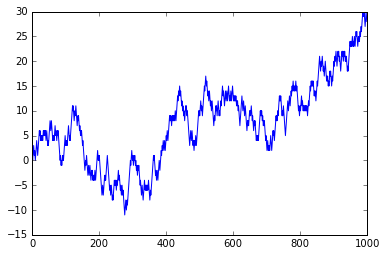

In [55]:
# Number of iterations
n_iter = 1000
# environment specs
env = EvidenceEnv(n=2, p=0.95)
# define agent
rndm_agent = RandomAgent(env)

reward = run(env, rndm_agent, n_iter)
reward_accumulated = np.cumsum(reward)

plt.figure(1)
plt.plot(reward_accumulated)    

### Assignment 2: Q-learning
In the second part of the assignment, a q-learning agent is implemented which predicts the action to chose based on observations and predicted reward.

In [56]:
class QLearnAgent(object):
    def __init__(self, env, alpha, lamb):
        self.env = env
        n_inputs = env.n_input
        n_actions = env.n_action
        self.q_table = np.zeros((2**n_inputs, n_actions))
        
        self.alpha = alpha
        self.lamb = lamb
        
    def act(self, observation):
#         Determine the index of the observation
        idx = self.env.asint(observation)
#         Determine the action with the maximum q-value for the
#         current observation
        action = np.argmax(self.q_table[idx])
        return action
    
    def train(self, a, old_obs, r, new_obs):
#         Determine the index of the observations
        old_idx = self.env.asint(old_obs)
        new_idx = self.env.asint(new_obs)
#         Return the maximum q-value of the new observation 
        fut_q = np.amax(self.q_table[new_idx])
        
#         Compute new q-values using the Bellman equation
        self.q_table[old_idx][a] = self.q_table[old_idx][a]+self.alpha*(r+self.lamb*fut_q-self.q_table[old_idx][a])

2
Table of start q-values
       Action 0  Action 1
[0,0]       0.0       0.0
[0,1]       0.0       0.0
[1,0]       0.0       0.0
[1,1]       0.0       0.0
Table of final q-values
       Action 0  Action 1
[0,0]  6.970630  0.000000
[0,1]  7.494076  0.000000
[1,0]  8.264542  0.000000
[1,1] -0.800000  9.904781


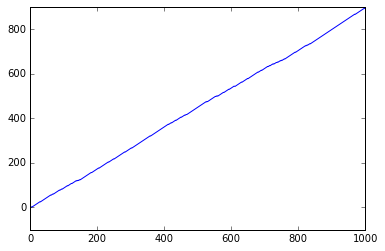

In [57]:
print(env.n_action)
qlearn_agent = QLearnAgent(env, .8, .9)
old_qtable = pd.DataFrame(qlearn_agent.q_table, index=("[0,0]","[0,1]","[1,0]", "[1,1]"), columns=("Action 0", "Action 1"))
print("Table of start q-values")
print(old_qtable)

reward = run(env, qlearn_agent, n_iter)
reward_accumulated = np.cumsum(reward)

plt.figure(2)
plt.plot(reward_accumulated)

new_qtable = pd.DataFrame(qlearn_agent.q_table, index=("[0,0]","[0,1]","[1,0]", "[1,1]"), columns=("Action 0", "Action 1"))

print("Table of final q-values")
print(new_qtable)

### Assignment 3
Last, a neural q-agent will be implemented; an MLP that takes observations and learns to 
compute the Q value for all possible actions.

In [119]:
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer import link
from chainer.functions.loss import mean_squared_error
from chainer.functions.evaluation import accuracy
from chainer import reporter


In [120]:
class MLP(Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units)
            self.l2 = L.Linear(None, n_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

In [121]:
class Regressor(link.Chain):

    compute_accuracy = False

    def __init__(self, predictor,
                 lossfun=mean_squared_error.mean_squared_error,
                 accfun=accuracy.accuracy,
                 label_key=-1):
        if not (isinstance(label_key, (int, str))):
            raise TypeError('label_key must be int or str, but is %s' %
                            type(label_key))

        super(Regressor, self).__init__()
        self.lossfun = lossfun
        self.accfun = accfun
        self.y = None
        self.loss = None
        self.accuracy = None
        self.label_key = label_key

        with self.init_scope():
            self.predictor = predictor

    def __call__(self, *args, **kwargs):

        if isinstance(self.label_key, int):
            if not (-len(args) <= self.label_key < len(args)):
                msg = 'Label key %d is out of bounds' % self.label_key
                raise ValueError(msg)
            t = args[self.label_key]
            if self.label_key == -1:
                args = args[:-1]
            else:
                args = args[:self.label_key] + args[self.label_key + 1:]
        elif isinstance(self.label_key, str):
            if self.label_key not in kwargs:
                msg = 'Label key "%s" is not found' % self.label_key
                raise ValueError(msg)
            t = kwargs[self.label_key]
            del kwargs[self.label_key]

        self.y = None
        self.loss = None
        self.accuracy = None
        self.y = self.predictor(*args, **kwargs)
        self.loss = self.lossfun(self.y, t)
        reporter.report({'loss': self.loss}, self)
        return self.loss

In [139]:
def squared_error(x0, x1):
    """Squared error function.
    This function computes the squared error between two variables:
    .. math::
        (x_0 - x_1)^2
    where operation is done in elementwise manner.
    Note that the error is not scaled by 1/2:
    Args:
        x0 (:class:`~chainer.Variable` or :class:`numpy.ndarray` or \
        :class:`cupy.ndarray`): Input variable.
        x1 (:class:`~chainer.Variable` or :class:`numpy.ndarray` or \
        :class:`cupy.ndarray`): Input variable.
    Returns:
        ~chainer.Variable:
            A variable holding an array representing the squared error of
            two inputs.
    """
    print(x0)
    print(x1)
    output = F.SquaredError()(x0, x1)
    print(output)
    return output

In [173]:
def squared_difference(x1, x2):
    """Squared difference of input variables.
    Args:
        x1 (~chainer.Variable): Input variables to be compared.
        x2 (~chainer.Variable): Input variables to be compared.
    Returns:
        ~chainer.Variable: ``(x1 - x2) ** 2`` element-wise.
    """
    print(x1)
    print(x2)
    sum = 0
    for x1_el, x2_el in zip(x1, x2):
        sum += (x1_el-x2_el) ** 2
    sum = np.sum(sum)
    print(sum)
    return sum

In [174]:
class NeuralQAgent(object):
    def __init__(self, lamb):        
        self.lamb = lamb
        
        self.mlp = MLP(10, 2)
        self.regressor = Regressor(self.mlp, squared_difference)
        self.optimizer = optimizers.SGD()
        self.optimizer.setup(self.regressor)
        
    def act(self, observation):
        # transform observation into correct dimensions
        observation = np.array([observation])
        
        # compute q-values for all actions
        qvalues = self.mlp(observation).data[0]
        
        # choose action with the highest q-value
        if(qvalues[0]>qvalues[1]):
            return 0
        else:
            return 1
    
    def train(self, a, old_obs, r, new_obs):
        # transform observations into correct dimensions
        old_obs = np.array([old_obs])
        new_obs = np.array([new_obs])
        
        # compute q-values for old and new observations
        q_old = self.mlp(old_obs).data[0]
        q_new = self.mlp(new_obs).data[0]
        
        # select the action for the new observation with the highest q-value
        maxa_new = np.amax(q_new)
        idx_maxa_new = np.argmax(q_new)
        
        # initialize target q-values, and
        tgt_q = q_new
        # set the target q-value for action a
        tgt_q[idx_maxa_new] = r+self.lamb*maxa_new
        tgt_q = Variable(np.array([tgt_q]))
        
        # calculate loss and backpropagate
        loss = self.regressor(old_obs, tgt_q)
        loss.backward()
        self.optimizer.update()

variable([[ 0.  0.]])
variable([[-1.  0.]])
variable(1.0)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ nan  nan]])
variable([[ nan  nan]])
variable(nan)
variable([[ 

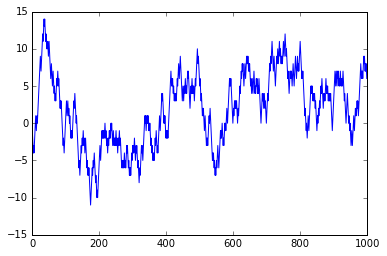

In [175]:
neuralq_agent = NeuralQAgent(.9)

reward = run(env, neuralq_agent, n_iter)
reward_accumulated = np.cumsum(reward)

plt.figure(3)
plt.plot(reward_accumulated)    